Data ophalen. Dit is een aangepaste view.

In [203]:
from pymysql import Connect
import pandas as pd
import pyodbc, psycopg2

db_conn = psycopg2.connect(database="depdatabase", user="postgres", password="DaddySzymon123", host="vichogent.be", port="40033")

cursor = db_conn.cursor()

cursor.execute(f"""
        select * from view_machine_learning_data
""")

df = pd.DataFrame(cursor.fetchall(), columns=['ondernemingsnummer', 'urban','balanstotaal','omzet', 'personeelsbestanden', 'foundingdate', 'environment','social','governance', 'general'])

In [205]:
df.head()

,ondernemingsnummer,urban,balanstotaal,omzet,personeelsbestanden,foundingdate,environment,social,governance,general
0,410917437,0.0,None,None,NaN,1961-03-30,0.0,0.018586,0.029217,0.015934
1,461056836,1.875,2805793.44,0,10.0,1997-07-07,0.0,0.000000,0.710802,0.236934
2,219395192,0.8490566037735849,None,None,NaN,1979-02-13,0.0,0.000000,0.633410,0.211137
3,447763183,1.4137931034482758,478133071.39,2438500.28,10.0,1992-06-30,0.0,0.000000,0.715486,0.238495
4,432406994,0.6572222,39999869.6,65496051.3,45.0,1987-11-10,0.0,0.000000,0.795257,0.265086


In [206]:
df['social'] = df['social']  * 100
df['governance'] = df['governance']  * 100
df['environment'] = df['environment'] * 100
df['general'] = df['general'] * 100

Null-waarden droppen

In [207]:
df = df.dropna()

In [208]:
len(df)

8678

In [209]:
df.head()

,ondernemingsnummer,urban,balanstotaal,omzet,personeelsbestanden,foundingdate,environment,social,governance,general
1,461056836,1.875,2805793.44,0,10.0,1997-07-07,0.0,0.000000,71.080217,23.693406
3,447763183,1.4137931034482758,478133071.39,2438500.28,10.0,1992-06-30,0.0,0.000000,71.548584,23.849528
4,432406994,0.6572222,39999869.6,65496051.3,45.0,1987-11-10,0.0,0.000000,79.525686,26.508562
5,417609051,0.7692307692307693,26922177.69,50191983.53,66.0,1977-10-13,0.0,1.858598,0.000000,0.619533
6,432893182,0.2121212121212121,25955521,43827278,18.0,1988-01-04,0.0,0.000000,4.408594,1.469531


Omzetten naar de gepaste datatypes:

In [210]:
df['omzet'] = df['omzet'].astype('int64')
df['balanstotaal'] = df['balanstotaal'].astype('int64')
df['personeelsbestanden'] = df['personeelsbestanden'].astype('int64')
df['urban'] = df['urban'].astype('float64')
df['foundingdate'] = (pd.Timestamp.now() - pd.to_datetime(df['foundingdate'], format="%Y-%m-%d")).dt.days / 365
df['environment'] = df['environment'].astype('float64')
df['social'] = df['social'].astype('float64')
df['governance'] = df['governance'].astype('float64')

In [211]:
df.dtypes

ondernemingsnummer       int64
urban                  float64
balanstotaal             int64
omzet                    int64
personeelsbestanden      int64
foundingdate           float64
environment            float64
social                 float64
governance             float64
general                float64
dtype: object

In [212]:
len(df)

8678

In [213]:
X = df.drop(['general', 'environment','social','governance', 'ondernemingsnummer'], axis=1)
y = df['general']

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

In [214]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

numerical_ix = X.select_dtypes(include=['int32','int64','float64']).columns

col_transform = ColumnTransformer(transformers=[
    ('minmax',MinMaxScaler(), numerical_ix),
])

# Data-Analyse

<AxesSubplot:xlabel='environment', ylabel='Count'>

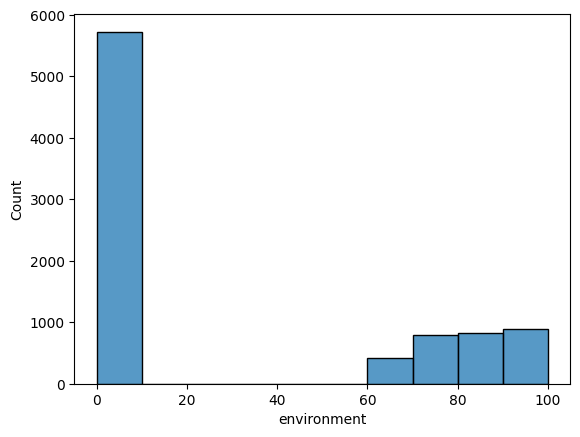

In [215]:
import seaborn as sns
sns.histplot(data=df, x='environment', bins=10)

<AxesSubplot:xlabel='social', ylabel='Count'>

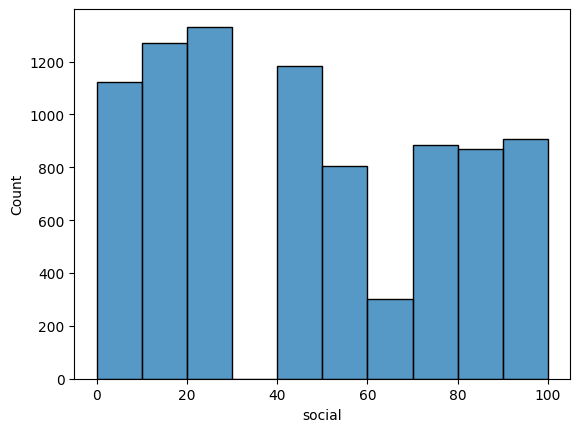

In [216]:
sns.histplot(data=df, x='social', bins=10)

<AxesSubplot:xlabel='governance', ylabel='Count'>

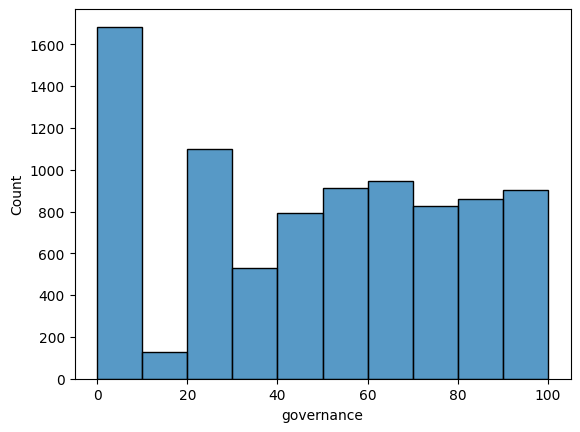

In [217]:
sns.histplot(data=df, x='governance', bins=10)

# ANN: Drie outputs

In [218]:
import tensorflow as tf

# Define the model architecture
model = tf.keras.Sequential([
    # Add a fully connected layer with 64 units and ReLU activation
    tf.keras.layers.Dense(64, activation='relu', input_shape=(5,)),
    # Add a fully connected layer with 32 units and ReLU activation
    tf.keras.layers.Dense(32, activation='relu'),
    # Add a fully connected layer with 3 units and sigmoid activation
    tf.keras.layers.Dense(3, activation='sigmoid')
])

# Compile the model with a mean squared error loss function and an Adam optimizer
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])


In [219]:
X

,urban,balanstotaal,omzet,personeelsbestanden,foundingdate
1,1.875000,2805793,0,10,25.465753
3,1.413793,478133071,2438500,10,30.487671
4,0.657222,39999869,65496051,45,35.128767
5,0.769231,26922177,50191983,66,45.210959
6,0.212121,25955521,43827278,18,34.978082
...,...,...,...,...,...
12625,1.442786,601053389,45263118,93,43.991781
12627,0.819672,6665510,19686095,20,41.920548
12628,0.849057,155563377,9373091,48,54.131507
12629,1.283019,29987289,0,13,65.457534


In [220]:
# Define the input and output data
X = df.drop(['general', 'environment','social','governance', 'ondernemingsnummer'], axis=1)
y = df[['environment','social','governance']]

# Train the model
model.fit(X, y, epochs=100)

Epoch 1/100
272/272 [==============================] - 0s 794us/step - loss: 2903.7944 - accuracy: 0.2790
Epoch 2/100
272/272 [==============================] - 0s 780us/step - loss: 2899.8486 - accuracy: 0.2737
Epoch 3/100
272/272 [==============================] - 0s 731us/step - loss: 2878.3645 - accuracy: 0.2301
Epoch 4/100
272/272 [==============================] - 0s 728us/step - loss: 2878.3650 - accuracy: 0.2301
Epoch 5/100
272/272 [==============================] - 0s 713us/step - loss: 2878.3647 - accuracy: 0.2301
Epoch 6/100
272/272 [==============================] - 0s 725us/step - loss: 2878.3657 - accuracy: 0.2301
Epoch 7/100
272/272 [==============================] - 0s 707us/step - loss: 2878.3652 - accuracy: 0.2301
Epoch 8/100
272/272 [==============================] - 0s 729us/step - loss: 2878.3660 - accuracy: 0.2301
Epoch 9/100
272/272 [==============================] - 0s 758us/step - loss: 2878.3643 - accuracy: 0.2301
Epoch 10/100
272/272 [========================

In [221]:
from keras.models import load_model
model.save('ann-ult-score.h5')
ann = load_model('ann-ult-score.h5')

In [222]:
X_test

,urban,balanstotaal,omzet,personeelsbestanden,foundingdate
545,0.899990,7511764,33159690,14,17.621918
2552,0.000000,2711356,0,24,44.542466
8740,1.050000,18769150,24773295,57,28.008219
10944,0.426230,5438923,36175537,61,35.301370
1242,0.190476,16030405,29615904,35,17.846575
...,...,...,...,...,...
9546,0.552632,5894783,9734326,37,24.600000
6665,0.514286,2183552,0,7,13.010959
7679,0.485714,2173756,4595231,13,46.150685
1548,1.788591,4557373,7543496,15,108.627397


In [235]:
y_pred = model.predict(X_test)
y_pred[0][0]

55/55 [==============================] - 0s 591us/step


44.369854

# ANN: General Score berekenen

In [237]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense

X = df.drop(['general', 'environment','social','governance', 'ondernemingsnummer'], axis=1)
y = df['general']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential()
model.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {test_loss}')


Test loss: 632.874755859375


In [245]:
from keras.models import load_model
model.save('ann-general-score.h5')
ann = load_model('ann-general-score.h5')

In [246]:
new_data = np.array([[1, 224455, 123687, 12, 43]])
new_data = scaler.transform(new_data)
prediction = ann.predict(new_data)
print(prediction)

1/1 [==============================] - 0s 57ms/step
[[37.277664]]


c:\Users\Dylan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


# E berekenen

In [227]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense

X = df.drop(['general', 'environment','social','governance', 'ondernemingsnummer'], axis=1)
y = df['environment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential()
model.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {test_loss}')

Test loss: 1456.2628173828125


In [228]:
from keras.models import load_model
model.save('ann-environment-score.h5')
ann = load_model('ann-environment-score.h5')

In [229]:
new_data = np.array([[1, 224455, 123687, 12, 43]])
new_data = scaler.transform(new_data)
prediction = ann.predict(new_data)
print(prediction)

1/1 [==============================] - 0s 32ms/step
[[28.329458]]


c:\Users\Dylan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


# S berekenen

In [230]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense

X = df.drop(['general', 'environment','social','governance', 'ondernemingsnummer'], axis=1)
y = df['social']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential()
model.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {test_loss}')

Test loss: 778.2720947265625


In [231]:
from keras.models import load_model
model.save('ann-social-score.h5')
ann = load_model('ann-social-score.h5')

In [232]:
new_data = np.array([[1, 224455, 123687, 12, 43]])
new_data = scaler.transform(new_data)
prediction = ann.predict(new_data)
print(prediction)

1/1 [==============================] - 0s 32ms/step
[[40.823322]]


c:\Users\Dylan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


# G berekenen

In [233]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense

X = df.drop(['general', 'environment','social','governance', 'ondernemingsnummer'], axis=1)
y = df['governance']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential()
model.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {test_loss}')

Test loss: 784.4097290039062


In [234]:
from keras.models import load_model
model.save('ann-governance-score.h5')
ann = load_model('ann-governance-score.h5')